# Assignment 4: Street Networks & Web Scraping

**Part 1: Visualizing crash data in Philadelphia**

In this section, you will use `osmnx` to analyze the crash incidence in Center City. 


**Part 2: Scraping Craigslist**

In this section, you will use Selenium and BeautifulSoup to scrape data for hundreds of apartments from Philadelphia's Craigslist portal.



## Part 1: Visualizing crash data in Philadelphia

1.1 Load the geometry for the region being analyzed
We'll analyze crashes in the "Central" planning district in Philadelphia, a rough approximation for Center City. Planning districts can be loaded from Open Data Philly. Read the data into a GeoDataFrame using the following link:

http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson

Select the "Central" district and extract the geometry polygon for only this district. After this part, you should have a polygon variable of type shapely.geometry.polygon.Polygon

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import hvplot.pandas 
import altair as alt
import matplotlib.pyplot as plt
import rasterio as rio
import osmnx as ox
pd.options.display.max_columns = 999

# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

In [2]:
CPD = gpd.read_file("http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson")
#CPD = ox.geocode_to_gdf("http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson")
CPD = CPD[CPD["ABBREV"] == "CTR"]
CPD

,OBJECTID_1,OBJECTID,DIST_NAME,ABBREV,Shape__Area,Shape__Length,PlanningDist,DaytimePop,geometry
3,4,9,Central,CTR,1.782880e+08,71405.14345,NaN,NaN,"POLYGON ((-75.14791 39.96733, -75.14715 39.967..."


In [3]:
Phillyox = ox.geocode_to_gdf("Philadelphia, PA")
Phillyox.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 1.2 Get the street network graph

Use OSMnx to create a network graph (of type 'drive') from your polygon boundary in 1.1.

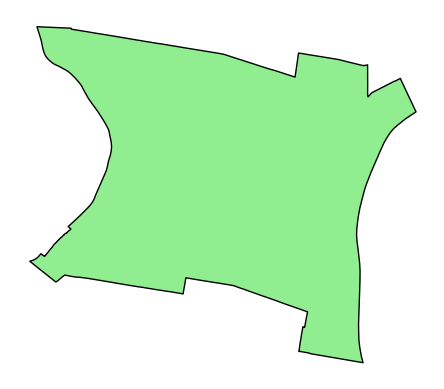

In [4]:
ax = ox.project_gdf(CPD).plot(fc="lightgreen", ec="black")
ax.set_axis_off()

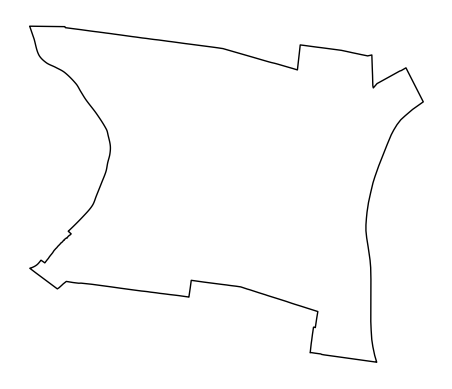

In [5]:
ax = CPD.to_crs(epsg=2272).plot(facecolor="none", edgecolor="black")
ax.set_axis_off()

In [6]:
streets = ox.features_from_place("Philadelphia, PA", tags={"highway": True})

In [7]:
streets.head(6)

highway                    geometry  \
element_type osmid                                                    
node         109727831  traffic_signals  POINT (-75.15328 40.02996)   
             109727914  traffic_signals  POINT (-75.13837 40.02803)   
             109727992  traffic_signals  POINT (-75.14616 40.02904)   
             109727997  traffic_signals  POINT (-75.14686 40.02914)   
             109728089   turning_circle  POINT (-74.99562 40.10542)   
             109728114  traffic_signals  POINT (-75.13897 40.03285)   

                       traffic_signals traffic_signals:direction railway  \
element_type osmid                                                         
node         109727831             NaN                       NaN     NaN   
             109727914          signal                       NaN     NaN   
             109727992          signal                       NaN     NaN   
             109727997             NaN                       NaN     NaN   
             109728089             NaN                       NaN     NaN   
             109728114          signal                       NaN     NaN   

                       crossing  ref noref noexit ref:left ref:right old_ref  \
element_type osmid                                                             
node         109727831      NaN  NaN   NaN    NaN      NaN       NaN     NaN   
             109727914      NaN  NaN   NaN    NaN      NaN       NaN     NaN   
             109727992      NaN  NaN   NaN    NaN      NaN       NaN     NaN   
             109727997      NaN  NaN   NaN    NaN      NaN       NaN     NaN   
             109728089      NaN  NaN   NaN    NaN      NaN       NaN     NaN   
             109728114      NaN  NaN   NaN    NaN      NaN       NaN     NaN   

                       disused:railway stop name crossing:markings direction  \
element_type osmid                                                             
node         109727831             NaN  NaN  NaN               NaN       NaN   
             109727914             NaN  NaN  NaN               NaN       NaN   
             109727992             NaN  NaN  NaN               NaN       NaN   
             109727997             NaN  NaN  NaN               NaN       NaN   
             109728089             NaN  NaN  NaN               NaN       NaN   
             109728114             NaN  NaN  NaN               NaN       NaN   

                       traffic_calming tactile_paving access source  \
element_type osmid                                                    
node         109727831             NaN            NaN    NaN    NaN   
             109727914             NaN            NaN    NaN    NaN   
             109727992             NaN            NaN    NaN    NaN   
             109727997             NaN            NaN    NaN    NaN   
             109728089             NaN            NaN    NaN    NaN   
             109728114             NaN            NaN    NaN    NaN   

                       crossing_ref bicycle description foot horse  \
element_type osmid                                                   
node         109727831          NaN     NaN         NaN  NaN   NaN   
             109727914          NaN     NaN         NaN  NaN   NaN   
             109727992          NaN     NaN         NaN  NaN   NaN   
             109727997          NaN     NaN         NaN  NaN   NaN   
             109728089          NaN     NaN         NaN  NaN   NaN   
             109728114          NaN     NaN         NaN  NaN   NaN   

                       motor_vehicle addr:city addr:housenumber addr:postcode  \
element_type osmid                                                              
node         109727831           NaN       NaN              NaN           NaN   
             109727914           NaN       NaN              NaN           NaN   
             109727992           NaN       NaN              NaN           NaN   
             109727997           NaN 

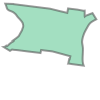

In [8]:
CPDoutline = CPD.squeeze().geometry
CPDoutline

In [9]:
G_CPD = ox.graph_from_polygon(CPDoutline, network_type="drive")

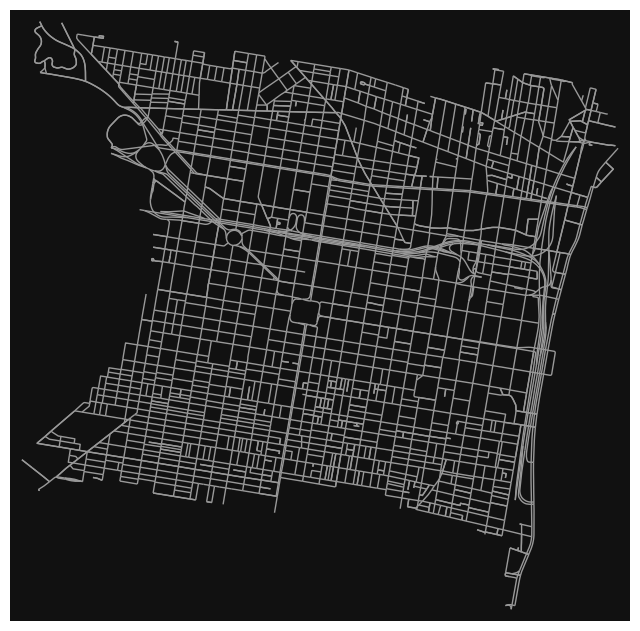

In [10]:
ox.plot_graph(ox.project_graph(G_CPD), node_size=0);

### 1.3 Convert your network graph edges to a GeoDataFrame

Use OSMnx to create a GeoDataFrame of the network edges in the graph object from part 1.2. The GeoDataFrame should contain the edges but not the nodes from the network.

In [11]:
CPD_edges = ox.graph_to_gdfs(G_CPD, edges=True, nodes=False)

In [12]:
CPD_edges

osmid  oneway                   name  \
u           v           key                                              
109727439   109911666   0     132508434    True      Bainbridge Street   
109727448   109727439   0      12109011    True  South Colorado Street   
            110034229   0      12159387    True       Fitzwater Street   
109727507   110024052   0     193364514    True       Carpenter Street   
109728761   110274344   0     672312336    True           Brown Street   
...                                 ...     ...                    ...   
11176163640 11176163648 1    1206065012   False                    NaN   
            5808113442  0     613950538   False        Alexander Court   
11176163648 5808113443  0     613950538   False        Alexander Court   
            11176163640 0     613950538   False        Alexander Court   
                        1    1206065012   False                    NaN   

                                   highway reversed   length  \
u           v           key                                    
109727439   109911666   0      residential    False   44.137   
109727448   109727439   0      residential    False  109.484   
            110034229   0      residential    False   91.353   
109727507   110024052   0      residential    False   53.208   
109728761   110274344   0      residential    False   58.270   
...                                    ...      ...      ...   
11176163640 11176163648 1    living_street    False   57.963   
            5808113442  0    living_street     True   37.086   
11176163648 5808113443  0    living_street    False   31.592   
            11176163640 0    living_street     True   14.738   
                        1    living_street     True   57.963   

                                                                      geometry  \
u           v           key                                                      
109727439   109911666   0    LINESTRING (-75.17104 39.94345, -75.17053 39.9...   
109727448   109727439   0    LINESTRING (-75.17125 39.94248, -75.17120 39.9...   
            110034229   0    LINESTRING (-75.17125 39.94248, -75.17137 39.9...   
109727507   110024052   0    LINESTRING (-75.17196 39.93973, -75.17134 39.9...   
109728761   110274344   0    LINESTRING (-75.17317 39.96951, -75.17250 39.9...   
...                                                                        ...   
11176163640 11176163648 1    LINESTRING (-75.16655 39.95896, -75.16633 39.9...   
            5808113442  0    LINESTRING (-75.16655 39.95896, -75.16662 39.9...   
11176163648 5808113443  0    LINESTRING (-75.16652 39.95909, -75.16646 39.9...   
            11176163640 0    LINESTRING (-75.16652 39.95909, -75.16655 39.9...   
                        1    LINESTRING (-75.16652 39.95909, -75.16630 39.9...   

                            maxspeed lanes bridge  ref tunnel width service  \
u           v           key                                                   
109727439   109911666   0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109727448   109727439   0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
            110034229   0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109727507   110024052   0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
109728761   110274344   0     25 mph   NaN    NaN  NaN    NaN   NaN     NaN   
...                              ...   ...    ...  ...    ...   ...     ...   
11176163640 11176163648 1        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
            5808113442  0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
11176163648 5808113443  0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
            11176163640 0        NaN   NaN    NaN  NaN    NaN   NaN     NaN   
                        1        NaN   NaN    NaN  NaN    NaN   NaN     NaN   

                            access junction  
u           v           key                  
109727439   109911666   0      NaN      NaN  
10972

### 1.4 Load PennDOT crash data

Data for crashes (of all types) for 2020, 2021, and 2022 in Philadelphia County is available at the following path:

`./data/CRASH_PHILADELPHIA_XXXX.csv`

You should see three separate files in the `data/` folder. Use pandas to read each of the CSV files, and combine them into a single dataframe using `pd.concat()`.

The data was downloaded for Philadelphia County [from here](https://crashinfo.penndot.gov/PCIT/welcome.html).

In [13]:
crash2020 = pd.read_csv("./Data/CRASH_PHILADELPHIA_2020.csv")
crash2021 = pd.read_csv("./Data/CRASH_PHILADELPHIA_2021.csv")
crash2022 = pd.read_csv("./Data/CRASH_PHILADELPHIA_2022.csv")
crashDf = pd.concat([crash2020, crash2021, crash2022])
crashDf

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,CHLDPAS_SUSP_SERIOUS_INJ_COUNT,COLLISION_TYPE,COMM_VEH_COUNT,CONS_ZONE_SPD_LIM,COUNTY,CRASH_MONTH,CRASH_YEAR,DAY_OF_WEEK,DEC_LAT,DEC_LONG,DISPATCH_TM,DISTRICT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,EST_HRS_CLOSED,FATAL_COUNT,HEAVY_TRUCK_COUNT,HORSE_BUGGY_COUNT,HOUR_OF_DAY,ILLUMINATION,INJURY_COUNT,INTERSECT_TYPE,INTERSECTION_RELATED,LANE_CLOSED,LATITUDE,LN_CLOSE_DIR,LOCATION_TYPE,LONGITUDE,MAX_SEVERITY_LEVEL,MCYCLE_DEATH_COUNT,MCYCLE_SUSP_SERIOUS_INJ_COUNT,MOTORCYCLE_COUNT,MUNICIPALITY,NONMOTR_COUNT,NONMOTR_DEATH_COUNT,NONMOTR_SUSP_SERIOUS_INJ_COUNT,NTFY_HIWY_MAINT,PED_COUNT,PED_DEATH_COUNT,PED_SUSP_SERIOUS_INJ_COUNT,PERSON_COUNT,POLICE_AGCY,POSSIBLE_INJ_COUNT,RDWY_SURF_TYPE_CD,RELATION_TO_ROAD,ROAD_CONDITION,ROADWAY_CLEARED,SCH_BUS_IND,SCH_ZONE_IND,SECONDARY_CRASH,SMALL_TRUCK_COUNT,SPEC_JURIS_CD,SUSP_MINOR_INJ_COUNT,SUSP_SERIOUS_INJ_COUNT,SUV_COUNT,TCD_FUNC_CD,TCD_TYPE,TFC_DETOUR_IND,TIME_OF_DAY,TOT_INJ_COUNT,TOTAL_UNITS,UNB_DEATH_COUNT,UNB_SUSP_SERIOUS_INJ_COUNT,UNBELTED_OCC_COUNT,UNK_INJ_DEG_COUNT,UNK_INJ_PER_COUNT,URBAN_AREA,URBAN_RURAL,VAN_COUNT,VEHICLE_COUNT,WEATHER1,WEATHER2,WORK_ZONE_IND,WORK_ZONE_LOC,WORK_ZONE_TYPE,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED
0,2020036588,1349.0,1,0,0,0,0,0,0,0,0,1,0,NaN,67,3,2020,2,39.9601,-75.1794,1343.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,13,1,0,0,NaN,1,39 57:36.245,4.0,0,75 10:45.819,0,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,9,NaN,N,N,NaN,1,NaN,0,0,0,0,0,N,1332,0,2,0,0,0,0,0,3,4,0,2,7,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020036617,1842.0,1,0,0,0,0,0,0,0,0,7,0,NaN,67,4,2020,1,39.9809,-75.2065,1840.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,18,1,0,0,NaN,1,39 58:51.367,3.0,0,75 12:23.366,0,0,0,0,67301,0,0,0,N,0,0,0,1,68K01,0,NaN,2,9,NaN,N,N,NaN,0,NaN,0,0,0,0,0,N,1838,0,1,0,0,0,0,0,3,4,0,1,7,7.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020035717,2000.0,1,0,0,0,0,0,0,0,0,2,0,NaN,67,4,2020,1,39.9269,-75.1691,2000.0,6,0,0,0,0,0,1,0,0,NaN,0,0,0.0,14,1,1,1,NaN,9,39 55:36.660,NaN,0,75 10:08.677,3,0,0,0,67301,0,0,0,N,0,0,0,2,67301,0,NaN,1,9,NaN,N,N,NaN,0,NaN,1,0,1,3,3,U,1457,1,2,0,0,0,0,0,3,4,0,2,7,4.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020034378,1139.0,2,0,0,0,0,0,0,0,0,1,0,NaN,67,4,2020,4,39.9237,-75.1924,1131.0,6,0,0,0,0,0,2,0,0,NaN,0,0,0.0,11,1,1,0,NaN,0,39 55:25.183,NaN,0,75 11:32.758,3,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,1,NaN,N,N,NaN,1,NaN,1,0,0,0,0,NaN,1128,1,3,0,0,0,0,0,3,4,0,3,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020025511,345.0,1,0,0,0,0,0,0,0,0,7,0,NaN,67,3,2020,1,39.8826,-75.2450,329.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,3,3,2,0,NaN,0,39 52:57.717,NaN,0,75 14:41.931,3,0,0,0,67301,0,0,0,Y,0,0,0,2,68K01,0,NaN,4,1,NaN,N,N,NaN,0,NaN,2,0,0,0,0,NaN,328,2,1,0,0,0,0,0,3,4,0,1,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8746,2022016289,2245.0,3,0,0,0,0,0,0,0,0,4,0,NaN,67,1,2022,4,40.0239,-75.1425,2242.0,6,0,0,0,1,0,0,0,0,NaN,0,0,0.0,22,3,1,1,NaN,0,40 01:25.870,NaN,0,75 08:33.165,3,0,0,0,67301,0,0,0,N,0,0,0,2,67301,0,NaN,1,1,NaN,N,N,N,0,NaN,1,0,1,3,3,NaN,2230,1,4,0,0,0,0,0,3,4,0,4,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8747,2022037461,1706.0,1,0,0,0,0,0,0,0,0,7,0,NaN,67,3,2022,4,39.9583,-75.1658,1644.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,16,1,1,7,NaN,0,39 57:29.748,NaN,2,75

### 1.5 Convert the crash data to a GeoDataFrame

You will need to use the `DEC_LAT` and `DEC_LONG` columns for latitude and longitude.

The full data dictionary for the data is [available here](http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data)

In [14]:
crashGDF = gpd.GeoDataFrame(crashDf, geometry=gpd.points_from_xy(crashDf["DEC_LONG"], crashDf["DEC_LAT"], crs="2272"))
crashGDF

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,CHLDPAS_SUSP_SERIOUS_INJ_COUNT,COLLISION_TYPE,COMM_VEH_COUNT,CONS_ZONE_SPD_LIM,COUNTY,CRASH_MONTH,CRASH_YEAR,DAY_OF_WEEK,DEC_LAT,DEC_LONG,DISPATCH_TM,DISTRICT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,EST_HRS_CLOSED,FATAL_COUNT,HEAVY_TRUCK_COUNT,HORSE_BUGGY_COUNT,HOUR_OF_DAY,ILLUMINATION,INJURY_COUNT,INTERSECT_TYPE,INTERSECTION_RELATED,LANE_CLOSED,LATITUDE,LN_CLOSE_DIR,LOCATION_TYPE,LONGITUDE,MAX_SEVERITY_LEVEL,MCYCLE_DEATH_COUNT,MCYCLE_SUSP_SERIOUS_INJ_COUNT,MOTORCYCLE_COUNT,MUNICIPALITY,NONMOTR_COUNT,NONMOTR_DEATH_COUNT,NONMOTR_SUSP_SERIOUS_INJ_COUNT,NTFY_HIWY_MAINT,PED_COUNT,PED_DEATH_COUNT,PED_SUSP_SERIOUS_INJ_COUNT,PERSON_COUNT,POLICE_AGCY,POSSIBLE_INJ_COUNT,RDWY_SURF_TYPE_CD,RELATION_TO_ROAD,ROAD_CONDITION,ROADWAY_CLEARED,SCH_BUS_IND,SCH_ZONE_IND,SECONDARY_CRASH,SMALL_TRUCK_COUNT,SPEC_JURIS_CD,SUSP_MINOR_INJ_COUNT,SUSP_SERIOUS_INJ_COUNT,SUV_COUNT,TCD_FUNC_CD,TCD_TYPE,TFC_DETOUR_IND,TIME_OF_DAY,TOT_INJ_COUNT,TOTAL_UNITS,UNB_DEATH_COUNT,UNB_SUSP_SERIOUS_INJ_COUNT,UNBELTED_OCC_COUNT,UNK_INJ_DEG_COUNT,UNK_INJ_PER_COUNT,URBAN_AREA,URBAN_RURAL,VAN_COUNT,VEHICLE_COUNT,WEATHER1,WEATHER2,WORK_ZONE_IND,WORK_ZONE_LOC,WORK_ZONE_TYPE,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED,geometry
0,2020036588,1349.0,1,0,0,0,0,0,0,0,0,1,0,NaN,67,3,2020,2,39.9601,-75.1794,1343.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,13,1,0,0,NaN,1,39 57:36.245,4.0,0,75 10:45.819,0,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,9,NaN,N,N,NaN,1,NaN,0,0,0,0,0,N,1332,0,2,0,0,0,0,0,3,4,0,2,7,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.179 39.960)
1,2020036617,1842.0,1,0,0,0,0,0,0,0,0,7,0,NaN,67,4,2020,1,39.9809,-75.2065,1840.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,18,1,0,0,NaN,1,39 58:51.367,3.0,0,75 12:23.366,0,0,0,0,67301,0,0,0,N,0,0,0,1,68K01,0,NaN,2,9,NaN,N,N,NaN,0,NaN,0,0,0,0,0,N,1838,0,1,0,0,0,0,0,3,4,0,1,7,7.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.207 39.981)
2,2020035717,2000.0,1,0,0,0,0,0,0,0,0,2,0,NaN,67,4,2020,1,39.9269,-75.1691,2000.0,6,0,0,0,0,0,1,0,0,NaN,0,0,0.0,14,1,1,1,NaN,9,39 55:36.660,NaN,0,75 10:08.677,3,0,0,0,67301,0,0,0,N,0,0,0,2,67301,0,NaN,1,9,NaN,N,N,NaN,0,NaN,1,0,1,3,3,U,1457,1,2,0,0,0,0,0,3,4,0,2,7,4.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.169 39.927)
3,2020034378,1139.0,2,0,0,0,0,0,0,0,0,1,0,NaN,67,4,2020,4,39.9237,-75.1924,1131.0,6,0,0,0,0,0,2,0,0,NaN,0,0,0.0,11,1,1,0,NaN,0,39 55:25.183,NaN,0,75 11:32.758,3,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,1,NaN,N,N,NaN,1,NaN,1,0,0,0,0,NaN,1128,1,3,0,0,0,0,0,3,4,0,3,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.192 39.924)
4,2020025511,345.0,1,0,0,0,0,0,0,0,0,7,0,NaN,67,3,2020,1,39.8826,-75.2450,329.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,3,3,2,0,NaN,0,39 52:57.717,NaN,0,75 14:41.931,3,0,0,0,67301,0,0,0,Y,0,0,0,2,68K01,0,NaN,4,1,NaN,N,N,NaN,0,NaN,2,0,0,0,0,NaN,328,2,1,0,0,0,0,0,3,4,0,1,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.245 39.883)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8746,2022016289,2245.0,3,0,0,0,0,0,0,0,0,4,0,NaN,67,1,2022,4,40.0239,-75.1425,2242.0,6,0,0,0,1,0,0,0,0,NaN,0,0,0.0,22,3,1,1,NaN,0,40 01:25.870,NaN,0,75 08:33.165,3,0,0,0,67301,0,0,0,N,0,0,0,2,67301,0,NaN,1,1,NaN,N,N,N,0,NaN,1,0,1,3,3,NaN,2230,1,4,0,0,0,0,0,3,4,0,4,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.142 40.024)


### 1.6 Trim the crash data to Center City

1. Get the boundary of the edges data frame (from part 1.3). Accessing the `.geometry.unary_union.convex_hull` property will give you a nice outer boundary region.
1. Trim the crashes using the `within()` function of the crash GeoDataFrame to find which crashes are within the boundary.

There should be about 3,750 crashes within the Central district.

In [15]:
CPD_boundary = CPD_edges.geometry.unary_union.convex_hull
CC_crashes = crashGDF[crashGDF.within(CPD_boundary)]
CC_crashes

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,CHLDPAS_SUSP_SERIOUS_INJ_COUNT,COLLISION_TYPE,COMM_VEH_COUNT,CONS_ZONE_SPD_LIM,COUNTY,CRASH_MONTH,CRASH_YEAR,DAY_OF_WEEK,DEC_LAT,DEC_LONG,DISPATCH_TM,DISTRICT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,EST_HRS_CLOSED,FATAL_COUNT,HEAVY_TRUCK_COUNT,HORSE_BUGGY_COUNT,HOUR_OF_DAY,ILLUMINATION,INJURY_COUNT,INTERSECT_TYPE,INTERSECTION_RELATED,LANE_CLOSED,LATITUDE,LN_CLOSE_DIR,LOCATION_TYPE,LONGITUDE,MAX_SEVERITY_LEVEL,MCYCLE_DEATH_COUNT,MCYCLE_SUSP_SERIOUS_INJ_COUNT,MOTORCYCLE_COUNT,MUNICIPALITY,NONMOTR_COUNT,NONMOTR_DEATH_COUNT,NONMOTR_SUSP_SERIOUS_INJ_COUNT,NTFY_HIWY_MAINT,PED_COUNT,PED_DEATH_COUNT,PED_SUSP_SERIOUS_INJ_COUNT,PERSON_COUNT,POLICE_AGCY,POSSIBLE_INJ_COUNT,RDWY_SURF_TYPE_CD,RELATION_TO_ROAD,ROAD_CONDITION,ROADWAY_CLEARED,SCH_BUS_IND,SCH_ZONE_IND,SECONDARY_CRASH,SMALL_TRUCK_COUNT,SPEC_JURIS_CD,SUSP_MINOR_INJ_COUNT,SUSP_SERIOUS_INJ_COUNT,SUV_COUNT,TCD_FUNC_CD,TCD_TYPE,TFC_DETOUR_IND,TIME_OF_DAY,TOT_INJ_COUNT,TOTAL_UNITS,UNB_DEATH_COUNT,UNB_SUSP_SERIOUS_INJ_COUNT,UNBELTED_OCC_COUNT,UNK_INJ_DEG_COUNT,UNK_INJ_PER_COUNT,URBAN_AREA,URBAN_RURAL,VAN_COUNT,VEHICLE_COUNT,WEATHER1,WEATHER2,WORK_ZONE_IND,WORK_ZONE_LOC,WORK_ZONE_TYPE,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED,geometry
0,2020036588,1349.0,1,0,0,0,0,0,0,0,0,1,0,NaN,67,3,2020,2,39.9601,-75.1794,1343.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,13,1,0,0,NaN,1,39 57:36.245,4.0,0,75 10:45.819,0,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,9,NaN,N,N,NaN,1,NaN,0,0,0,0,0,N,1332,0,2,0,0,0,0,0,3,4,0,2,7,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.179 39.960)
7,2020035021,1255.0,1,0,0,0,0,0,1,0,0,4,1,NaN,67,3,2020,2,39.9700,-75.1631,1250.0,6,0,0,0,0,0,1,0,0,NaN,0,0,0.0,12,1,2,1,NaN,0,39 58:11.995,NaN,0,75 09:47.193,8,0,0,0,67301,0,0,0,N,0,0,0,4,67508,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,3,3,N,1250,2,2,0,0,0,2,1,3,4,0,2,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.163 39.970)
11,2020021944,805.0,2,0,0,0,0,0,0,0,0,1,0,NaN,67,2,2020,7,39.9523,-75.1878,800.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,8,1,2,0,NaN,2,39 57:08.258,4.0,0,75 11:16.213,3,0,0,0,67301,0,0,0,N,0,0,0,2,67504,0,NaN,6,1,NaN,N,N,NaN,0,NaN,2,0,0,0,0,N,800,2,2,0,0,2,0,0,3,4,0,2,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.188 39.952)
12,2020024963,1024.0,1,0,0,0,0,0,0,0,0,5,1,NaN,67,3,2020,2,39.9558,-75.1484,1024.0,6,0,0,0,0,0,0,0,0,NaN,0,1,0.0,10,1,0,0,NaN,0,39 57:21.042,NaN,2,75 08:54.233,0,0,0,0,67301,0,0,0,N,0,0,0,2,67501,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,0,0,NaN,1024,0,2,0,0,0,0,0,3,4,0,2,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.148 39.956)
18,2020000481,1737.0,1,0,0,0,0,0,1,0,0,5,1,NaN,67,1,2020,4,39.9534,-75.1547,1737.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,17,4,0,1,NaN,0,39 57:12.069,NaN,0,75 09:16.934,0,0,0,0,67301,0,0,0,N,0,0,0,2,67301,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,3,2,NaN,1735,0,2,0,0,0,0,0,3,4,0,2,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.155 39.953)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2022019573,2210.0,0,0,0,0,0,0,0,0,0,8,0,NaN,67,1,2022,5,39.9556,-75.1728,2205.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,21,3,1,1,NaN,0,39 57:20.163,NaN,0,75 10:21.961,3,0,0,0,67301,1,0,0,N,1,0,0,2,67301,0,NaN,1,1,NaN,N,N,N,0,NaN,1,0,1,3,2,NaN,2145,1,2,0,0,0,0,1,3,4,0,1,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.173 39.95

### 1.7 Re-project our data into an approriate CRS

We'll need to find the nearest edge (street) in our graph for each crash. To do this, `osmnx` will calculate the distance from each crash to the graph edges. For this calculation to be accurate, we need to convert from latitude/longitude 

**We'll convert the local state plane CRS for Philadelphia, EPSG=2272**

#### Two steps:
1. Project the graph object (`G`) using the `ox.project_graph`. Run `ox.project_graph?` to see the documentation for how to convert to a specific CRS. 
1. Project the crash data using the `.to_crs()` function.

In [16]:
G_projected = ox.project_graph(G_CPD, to_crs=2272)
CC_crashproj = CC_crashes.to_crs(2272)
CC_crashproj

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,CHLDPAS_SUSP_SERIOUS_INJ_COUNT,COLLISION_TYPE,COMM_VEH_COUNT,CONS_ZONE_SPD_LIM,COUNTY,CRASH_MONTH,CRASH_YEAR,DAY_OF_WEEK,DEC_LAT,DEC_LONG,DISPATCH_TM,DISTRICT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,EST_HRS_CLOSED,FATAL_COUNT,HEAVY_TRUCK_COUNT,HORSE_BUGGY_COUNT,HOUR_OF_DAY,ILLUMINATION,INJURY_COUNT,INTERSECT_TYPE,INTERSECTION_RELATED,LANE_CLOSED,LATITUDE,LN_CLOSE_DIR,LOCATION_TYPE,LONGITUDE,MAX_SEVERITY_LEVEL,MCYCLE_DEATH_COUNT,MCYCLE_SUSP_SERIOUS_INJ_COUNT,MOTORCYCLE_COUNT,MUNICIPALITY,NONMOTR_COUNT,NONMOTR_DEATH_COUNT,NONMOTR_SUSP_SERIOUS_INJ_COUNT,NTFY_HIWY_MAINT,PED_COUNT,PED_DEATH_COUNT,PED_SUSP_SERIOUS_INJ_COUNT,PERSON_COUNT,POLICE_AGCY,POSSIBLE_INJ_COUNT,RDWY_SURF_TYPE_CD,RELATION_TO_ROAD,ROAD_CONDITION,ROADWAY_CLEARED,SCH_BUS_IND,SCH_ZONE_IND,SECONDARY_CRASH,SMALL_TRUCK_COUNT,SPEC_JURIS_CD,SUSP_MINOR_INJ_COUNT,SUSP_SERIOUS_INJ_COUNT,SUV_COUNT,TCD_FUNC_CD,TCD_TYPE,TFC_DETOUR_IND,TIME_OF_DAY,TOT_INJ_COUNT,TOTAL_UNITS,UNB_DEATH_COUNT,UNB_SUSP_SERIOUS_INJ_COUNT,UNBELTED_OCC_COUNT,UNK_INJ_DEG_COUNT,UNK_INJ_PER_COUNT,URBAN_AREA,URBAN_RURAL,VAN_COUNT,VEHICLE_COUNT,WEATHER1,WEATHER2,WORK_ZONE_IND,WORK_ZONE_LOC,WORK_ZONE_TYPE,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED,geometry
0,2020036588,1349.0,1,0,0,0,0,0,0,0,0,1,0,NaN,67,3,2020,2,39.9601,-75.1794,1343.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,13,1,0,0,NaN,1,39 57:36.245,4.0,0,75 10:45.819,0,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,9,NaN,N,N,NaN,1,NaN,0,0,0,0,0,N,1332,0,2,0,0,0,0,0,3,4,0,2,7,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.179 39.960)
7,2020035021,1255.0,1,0,0,0,0,0,1,0,0,4,1,NaN,67,3,2020,2,39.9700,-75.1631,1250.0,6,0,0,0,0,0,1,0,0,NaN,0,0,0.0,12,1,2,1,NaN,0,39 58:11.995,NaN,0,75 09:47.193,8,0,0,0,67301,0,0,0,N,0,0,0,4,67508,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,3,3,N,1250,2,2,0,0,0,2,1,3,4,0,2,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.163 39.970)
11,2020021944,805.0,2,0,0,0,0,0,0,0,0,1,0,NaN,67,2,2020,7,39.9523,-75.1878,800.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,8,1,2,0,NaN,2,39 57:08.258,4.0,0,75 11:16.213,3,0,0,0,67301,0,0,0,N,0,0,0,2,67504,0,NaN,6,1,NaN,N,N,NaN,0,NaN,2,0,0,0,0,N,800,2,2,0,0,2,0,0,3,4,0,2,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.188 39.952)
12,2020024963,1024.0,1,0,0,0,0,0,0,0,0,5,1,NaN,67,3,2020,2,39.9558,-75.1484,1024.0,6,0,0,0,0,0,0,0,0,NaN,0,1,0.0,10,1,0,0,NaN,0,39 57:21.042,NaN,2,75 08:54.233,0,0,0,0,67301,0,0,0,N,0,0,0,2,67501,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,0,0,NaN,1024,0,2,0,0,0,0,0,3,4,0,2,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.148 39.956)
18,2020000481,1737.0,1,0,0,0,0,0,1,0,0,5,1,NaN,67,1,2020,4,39.9534,-75.1547,1737.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,17,4,0,1,NaN,0,39 57:12.069,NaN,0,75 09:16.934,0,0,0,0,67301,0,0,0,N,0,0,0,2,67301,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,3,2,NaN,1735,0,2,0,0,0,0,0,3,4,0,2,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.155 39.953)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2022019573,2210.0,0,0,0,0,0,0,0,0,0,8,0,NaN,67,1,2022,5,39.9556,-75.1728,2205.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,21,3,1,1,NaN,0,39 57:20.163,NaN,0,75 10:21.961,3,0,0,0,67301,1,0,0,N,1,0,0,2,67301,0,NaN,1,1,NaN,N,N,N,0,NaN,1,0,1,3,2,NaN,2145,1,2,0,0,0,0,1,3,4,0,1,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.173 39.95

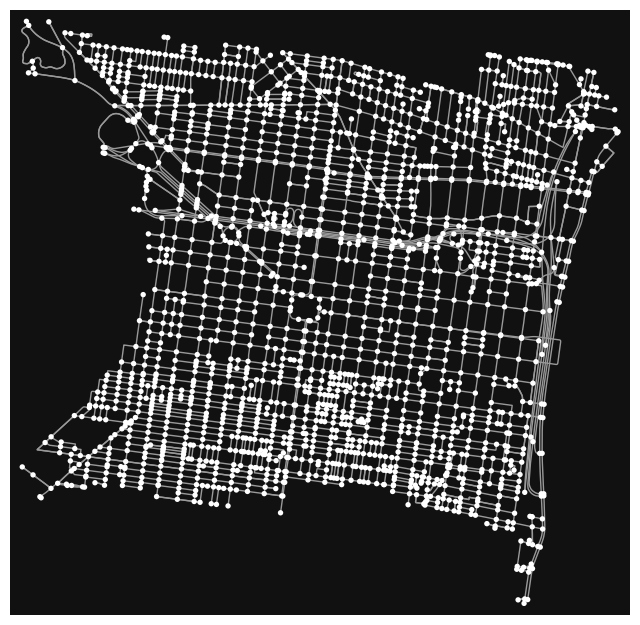

In [17]:
ox.plot_graph(G_projected);

### 1.8 Find the nearest edge for each crash

See: `ox.distance.nearest_edges()`. It takes three arguments:

- the network graph
- the longitude of your crash data (the `x` attribute of the `geometry` column)
- the latitude of your crash data (the `y` attribute of the `geometry` column)

You will get a numpy array with 3 columns that represent `(u, v, key)` where each `u` and `v` are the node IDs that the edge links together. We will ignore the `key` value for our analysis.

In [18]:
def find_nearest_edge(CC_crashproj, G_CPD):
    crash_longitudes = CC_crashproj.geometry.x
    crash_latitudes = CC_crashproj.geometry.y

    nearest_edges = ox.distance.nearest_edges(G_CPD, crash_longitudes, crash_latitudes)
    #CC_crashproj["nearest_edge"] = nearest_edges
    return nearest_edges

crashes_nearest_edge = find_nearest_edge(CC_crashproj, G_CPD)
#crashes_nearest_edge

### 1.9 Calculate the total number of crashes per street

1. Make a DataFrame from your data from part 1.7 with three columns, `u`, `v`, and `key` (we will only use the `u` and `v` columns)
1. Group by `u` and `v` and calculate the size
1. Reset the index and name your `size()` column as `crash_count`

After this step you should have a DataFrame with three columns: `u`, `v`, and `crash_count`.

In [19]:
CC_crashproj.head(4)

,CRN,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,CHLDPAS_SUSP_SERIOUS_INJ_COUNT,COLLISION_TYPE,COMM_VEH_COUNT,CONS_ZONE_SPD_LIM,COUNTY,CRASH_MONTH,CRASH_YEAR,DAY_OF_WEEK,DEC_LAT,DEC_LONG,DISPATCH_TM,DISTRICT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,EST_HRS_CLOSED,FATAL_COUNT,HEAVY_TRUCK_COUNT,HORSE_BUGGY_COUNT,HOUR_OF_DAY,ILLUMINATION,INJURY_COUNT,INTERSECT_TYPE,INTERSECTION_RELATED,LANE_CLOSED,LATITUDE,LN_CLOSE_DIR,LOCATION_TYPE,LONGITUDE,MAX_SEVERITY_LEVEL,MCYCLE_DEATH_COUNT,MCYCLE_SUSP_SERIOUS_INJ_COUNT,MOTORCYCLE_COUNT,MUNICIPALITY,NONMOTR_COUNT,NONMOTR_DEATH_COUNT,NONMOTR_SUSP_SERIOUS_INJ_COUNT,NTFY_HIWY_MAINT,PED_COUNT,PED_DEATH_COUNT,PED_SUSP_SERIOUS_INJ_COUNT,PERSON_COUNT,POLICE_AGCY,POSSIBLE_INJ_COUNT,RDWY_SURF_TYPE_CD,RELATION_TO_ROAD,ROAD_CONDITION,ROADWAY_CLEARED,SCH_BUS_IND,SCH_ZONE_IND,SECONDARY_CRASH,SMALL_TRUCK_COUNT,SPEC_JURIS_CD,SUSP_MINOR_INJ_COUNT,SUSP_SERIOUS_INJ_COUNT,SUV_COUNT,TCD_FUNC_CD,TCD_TYPE,TFC_DETOUR_IND,TIME_OF_DAY,TOT_INJ_COUNT,TOTAL_UNITS,UNB_DEATH_COUNT,UNB_SUSP_SERIOUS_INJ_COUNT,UNBELTED_OCC_COUNT,UNK_INJ_DEG_COUNT,UNK_INJ_PER_COUNT,URBAN_AREA,URBAN_RURAL,VAN_COUNT,VEHICLE_COUNT,WEATHER1,WEATHER2,WORK_ZONE_IND,WORK_ZONE_LOC,WORK_ZONE_TYPE,WORKERS_PRES,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,WZ_WORKERS_INJ_KILLED,geometry
0,2020036588,1349.0,1,0,0,0,0,0,0,0,0,1,0,NaN,67,3,2020,2,39.9601,-75.1794,1343.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,13,1,0,0,NaN,1,39 57:36.245,4.0,0,75 10:45.819,0,0,0,0,67301,0,0,0,N,0,0,0,3,68K01,0,NaN,1,9,NaN,N,N,NaN,1,NaN,0,0,0,0,0,N,1332,0,2,0,0,0,0,0,3,4,0,2,7,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.179 39.960)
7,2020035021,1255.0,1,0,0,0,0,0,1,0,0,4,1,NaN,67,3,2020,2,39.9700,-75.1631,1250.0,6,0,0,0,0,0,1,0,0,NaN,0,0,0.0,12,1,2,1,NaN,0,39 58:11.995,NaN,0,75 09:47.193,8,0,0,0,67301,0,0,0,N,0,0,0,4,67508,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,3,3,N,1250,2,2,0,0,0,2,1,3,4,0,2,3,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.163 39.970)
11,2020021944,805.0,2,0,0,0,0,0,0,0,0,1,0,NaN,67,2,2020,7,39.9523,-75.1878,800.0,6,0,0,0,0,0,0,0,0,NaN,0,0,0.0,8,1,2,0,NaN,2,39 57:08.258,4.0,0,75 11:16.213,3,0,0,0,67301,0,0,0,N,0,0,0,2,67504,0,NaN,6,1,NaN,N,N,NaN,0,NaN,2,0,0,0,0,N,800,2,2,0,0,2,0,0,3,4,0,2,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.188 39.952)
12,2020024963,1024.0,1,0,0,0,0,0,0,0,0,5,1,NaN,67,3,2020,2,39.9558,-75.1484,1024.0,6,0,0,0,0,0,0,0,0,NaN,0,1,0.0,10,1,0,0,NaN,0,39 57:21.042,NaN,2,75 08:54.233,0,0,0,0,67301,0,0,0,N,0,0,0,2,67501,0,NaN,1,1,NaN,N,N,NaN,0,NaN,0,0,0,0,0,NaN,1024,0,2,0,0,0,0,0,3,4,0,2,3,3.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.148 39.956)


In [20]:
nearest_edge_column = crashes_nearest_edge

NearestEdgedf = pd.DataFrame(nearest_edge_column, columns=["u", "v", "key"])

NearestEdgedf 

,u,v,key
0,8482829382,7065714513,0
1,109848091,109848089,0
2,1903608761,109775193,0
3,775424610,775424581,0
4,110416511,110417392,0
...,...,...,...
3746,110053344,110053369,0
3747,110453046,110318202,0
3748,8482829382,7065714513,0
3749,109791270,109783164,0


In [21]:
grouped_NearestEdgedf = NearestEdgedf.groupby(["u", "v"])


crash_count = grouped_NearestEdgedf.size().to_frame('size')
crash_count_df = crash_count.reset_index()
crash_count_df.rename(columns={"size": "crash_count"}, inplace=True)
crash_count_df


,u,v,crash_count
0,109729474,3425014859,2
1,109729486,110342146,4
2,109729673,109729699,3
3,109729699,109811674,6
4,109729709,109729731,3
...,...,...,...
875,10270051289,5519334546,5
876,10660521817,10660521823,1
877,10674041689,10674041689,22
878,11144117753,109729699,3


### 1.10 Merge your edges GeoDataFrame and crash count DataFrame

You can use pandas to merge them on the `u` and `v` columns. This will associate the total crash count with each edge in the street network. 

**Tips:** 
   - Use a `left` merge where the first argument of the merge is the edges GeoDataFrame. This ensures no edges are removed during the merge.
   - Use the `fillna(0)` function to fill in missing crash count values with zero.

In [22]:
merged_CPD = pd.merge(CPD_edges, crash_count_df, how="left", on=["u","v"]).fillna(0)
merged_CPD

,u,v,osmid,oneway,name,highway,reversed,length,geometry,maxspeed,lanes,bridge,ref,tunnel,width,service,access,junction,crash_count
0,109727439,109911666,132508434,True,Bainbridge Street,residential,False,44.137,"LINESTRING (-75.17104 39.94345, -75.17053 39.9...",0,0,0,0,0,0,0,0,0,0.0
1,109727448,109727439,12109011,True,South Colorado Street,residential,False,109.484,"LINESTRING (-75.17125 39.94248, -75.17120 39.9...",0,0,0,0,0,0,0,0,0,0.0
2,109727448,110034229,12159387,True,Fitzwater Street,residential,False,91.353,"LINESTRING (-75.17125 39.94248, -75.17137 39.9...",0,0,0,0,0,0,0,0,0,0.0
3,109727507,110024052,193364514,True,Carpenter Street,residential,False,53.208,"LINESTRING (-75.17196 39.93973, -75.17134 39.9...",0,0,0,0,0,0,0,0,0,0.0
4,109728761,110274344,672312336,True,Brown Street,residential,False,58.270,"LINESTRING (-75.17317 39.96951, -75.17250 39.9...",25 mph,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,11176163640,11176163648,1206065012,False,0,living_street,False,57.963,"LINESTRING (-75.16655 39.95896, -75.16633 39.9...",0,0,0,0,0,0,0,0,0,0.0
3892,11176163640,5808113442,613950538,False,Alexander Court,living_street,True,37.086,"LINESTRING (-75.16655 39.95896, -75.16662 39.9...",0,0,0,0,0,0,0,0,0,0.0
3893,11176163648,5808113443,613950538,False,Alexander Court,living_street,False,31.592,"LINESTRING (-75.16652 39.95909, -75.16646 39.9...",0,0,0,0,0,0,0,0,0,0.0
3894,11176163648,11176163640,613950538,False,Alexander Court,living_street,True,14.738,"LINESTRING (-75.16652 39.95909, -75.16655 39.9...",0,0,0,0,0,0,0,0,0,0.0


### 1.11 Calculate a "Crash Index"

Let's calculate a "crash index" that provides a normalized measure of the crash frequency per street. To do this, we'll need to:

1. Calculate the total crash count divided by the street length, using the `length` column
1. Perform a log transformation of the crash/length variable — use numpy's `log10()` function
1. Normalize the index from 0 to 1 (see the lecture notes for an example of this transformation)

**Note: since the crash index involves a log transformation, you should only calculate the index for streets where the crash count is greater than zero**.

After this step, you should have a new column in the data frame from 1.9 that includes a column called part 1.9.

In [23]:
merged_CPD['crash_count_real']= merged_CPD['crash_count'].where(merged_CPD['crash_count'] > 0)
merged_CPD = merged_CPD.dropna(axis=0)

In [32]:
merged_CPD["crash_per_length"] = merged_CPD['crash_count'] / merged_CPD["length"]
merged_CPD["crash_index"] = np.log10(merged_CPD["crash_per_length"]) 
crash_index = merged_CPD["crash_index"]
merged_CPD["crash_index_normalized"] = (crash_index - crash_index.min()) / (crash_index.max() - crash_index.min())
merged_CPD 

C:\Users\Owner\miniforge3\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,u,v,osmid,oneway,name,highway,reversed,length,geometry,maxspeed,lanes,bridge,ref,tunnel,width,service,access,junction,crash_count,crash_count_real,crash_per_length,crash_index,crash_index_normalized
14,109729474,3425014859,62154356,True,Arch Street,secondary,False,126.087,"LINESTRING (-75.14847 39.95259, -75.14859 39.9...",25 mph,2,0,0,0,0,0,0,0,2.0,2.0,0.015862,-1.799640,0.253014
15,109729486,110342146,"[12169305, 1052694387]",True,North Independence Mall East,secondary,False,123.116,"LINESTRING (-75.14832 39.95333, -75.14813 39.9...",0,"[2, 3]",0,0,0,0,0,0,0,4.0,4.0,0.032490,-1.488255,0.344052
22,109729673,109729699,30908050,True,North 5th Street,secondary,False,106.498,"LINESTRING (-75.14749 39.95686, -75.14748 39.9...",0,2,0,0,0,0,0,0,0,3.0,3.0,0.028170,-1.550220,0.325935
25,109729699,109811674,"[1047787360, 424804073, 1047787359]",True,Callowhill Street,trunk,False,135.769,"LINESTRING (-75.14724 39.95779, -75.14739 39.9...",35 mph,5,0,0,0,0,0,0,0,6.0,6.0,0.044193,-1.354649,0.383113
26,109729709,109811681,12166069,False,Willow Street,residential,False,135.689,"LINESTRING (-75.14714 39.95860, -75.14788 39.9...",0,0,0,0,0,0,0,0,0,4.0,4.0,0.029479,-1.530485,0.331705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3880,10660521817,10660521823,1145560245,False,0,residential,False,78.888,"LINESTRING (-75.18307 39.94021, -75.18315 39.9...",0,0,0,0,0,0,0,0,0,1.0,1.0,0.012676,-1.897011,0.224546
3882,10674041689,10674041689,1116747275,False,Arch Street,tertiary,False,59.612,"LINESTRING (-75.17821 39.95627, -75.17826 39.9...",0,0,0,0,0,0,0,0,0,22.0,22.0,0.369053,-0.432911,0.652595
3883,10674041689,10674041689,1116747275,False,Arch Street,tertiary,True,59.612,"LINESTRING (-75.17821 39.95627, -75.17827 39.9...",0,0,0,0,0,0,0,0,0,22.0,22.0,0.369053,-0.432911,0.652595
3886,11144117753,109729699,"[367831920, 50725362, 61756380, 12189165]",True,North 5th Street,secondary,False,470.874,"LINESTRING (-75.14814 39.95362, -75.14807 39.9...",25 mph,1,0,0,yes,0,0,0,0,3.0,3.0,0.006371,-2.195783,0.137196


### 1.12 Plot a histogram of the crash index values

Use matplotlib's `hist()` function to plot the crash index values from the previous step.

You should see that the index values are Gaussian-distributed, providing justification for why we log-transformed!

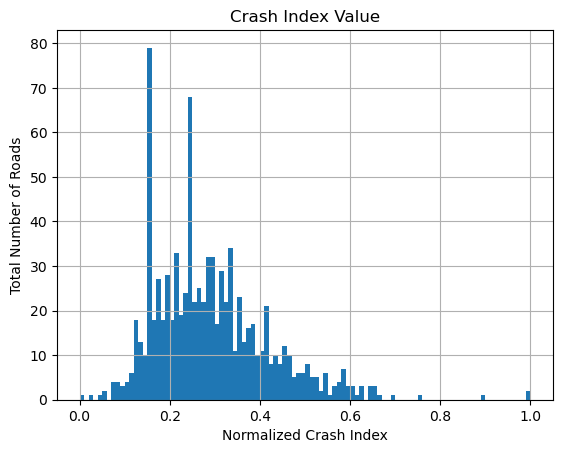

In [33]:
fig, ax = plt.subplots()
x = merged_CPD["crash_index_normalized"]
plt.hist(x, bins=100,),
plt.xlabel("Normalized Crash Index"),
plt.ylabel("Total Number of Roads"),
plt.title("Crash Index Value"),
plt.grid(True),
plt.show()

### 1.13 Plot an interactive map of the street networks, colored by the crash index

You can use GeoPandas to make an interactive Folium map, coloring the streets by the crash index column.

**Tip:** if you use the viridis color map, try using a "dark" tile set for better constrast of the colors.

In [35]:
import folium

In [36]:
m = merged_CPD.explore(
    column="crash_index_normalized",
    tiles="Cartodb dark matter",
)
m

## Part 2: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using Selenium and BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-550-Fall-2022/week-6/blob/main/css-selectors.md).

### Primer: the Craigslist website URL

We'll start with the Philadelphia region. First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. 

[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0)

There are **three** components to this URL. 

1. The base URL: `http://philadelphia.craigslist.org/search/apa`

2. The user's search parameters: `?min_price=1&min_bedrooms=1&minSqft=1`

> We will send nonzero defaults for some parameters (bedrooms, size, price) in order to exclude results that have empty values for these parameters.


3. The URL *hash*: `#search=1~gallery~0~0`

> As we will see later, this part will be important because it contains the search page result number.


The Craigslist website requires Javascript, so we'll need to use Selenium to load the page, and then use BeautifulSoup to extract the information we want. 



### 2.1 Initialize a selenium driver and open Craigslist

As discussed in lecture, you can use Chrome, Firefox, or Edge as your selenium driver. In this part, you should do two things:

1. Initialize the selenium driver
1. Use the `driver.get()` function to open the following URL:

[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0)

This will give you the search results for 1-bedroom apartments in Philadelphia.


In [183]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.by import By
import pandas as pd

In [184]:
driver = webdriver.Chrome()

C:\Users\Owner\AppData\Local\Temp\ipykernel_25652\537431734.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='nul'>
  driver = webdriver.Chrome()


In [185]:
url = "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1gallery0~0"
driver.get(url)

### 2.2 Initialize your "soup"

Once selenium has the page open, we can get the page source from the driver and use BeautifulSoup to parse it. In this part, initialize a BeautifulSoup object with the driver's page source



In [186]:
propertySoup = BeautifulSoup(driver.page_source, "html.parser")

### 2.3 Parsing the HTML

Now that we have our "soup" object, we can use BeautifulSoup to extract out the elements we need:

- Use the Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML. 


At the end of this part, you should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [187]:
element = propertySoup.select("li.cl-search-result")

In [188]:
#element

In [189]:
len(element)

120

In [190]:
print(element[0].prettify())
print(len(element))

<li class="cl-search-result cl-search-view-mode-gallery" data-pid="7678961565" title="A fresh take on living: Explore our 1 BR, 680 Sq Ft spaces.">
 <div class="gallery-card">
  <div class="cl-gallery">
   <div class="gallery-inner">
    <a class="main" href="https://philadelphia.craigslist.org/apa/d/north-wales-fresh-take-on-living/7678961565.html">
     <div class="swipe" style="visibility: visible;">
      <div class="swipe-wrap" style="width: 6768px;">
       <div data-index="0" style="width: 376px; left: 0px; transition-duration: 0ms; transform: translateX(0px);">
        <span class="loading icom-">
        </span>
        <img alt="A fresh take on living: Explore our 1 BR, 680 Sq Ft spaces. 1" src="https://images.craigslist.org/00Z0Z_g553W757i6Y_0ew09G_300x300.jpg"/>
       </div>
       <div data-index="1" style="width: 376px; left: -376px; transition-duration: 0ms; transform: translateX(376px);">
       </div>
       <div data-index="2" style="width: 376px; left: -752px; trans

### 2.4 Find the relevant pieces of information

We will now focus on the **first element** in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms
- The square footage
- The apartment title

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.


In [191]:
apt1 = element[0]
spans = apt1.select('span')
print(f"apartment price: {apt1.find('span',{'class' : 'priceinfo'}).text}",end="\n")

print(f"number of bedrooms: {apt1.find('span',{'class' : 'post-bedrooms'}).text[:1]}",end="\n")

print(f"square footage: {apt1.find('span',{'class' : 'post-sqft'}).text[:3]}",end="\n")

print(f"apartment title: {apt1.find('span',{'class' : 'label'}).text}",end="\n")

apartment price: $1,722
number of bedrooms: 1
square footage: 680
apartment title: A fresh take on living: Explore our 1 BR, 680 Sq Ft spaces.


### 2.5 Functions to format the results 

In this section, you'll create functions that take in the raw string elements for price, size, and number of bedrooms and returns them formatted as numbers.

I've started the functions to format the values. You should finish theses functions in this section.

**Hints**
- You can use string formatting functions like `string.replace()` and `string.strip()`
- The `int()` and `float()` functions can convert strings to numbers

In [192]:
def format_bedrooms(bedrooms_string):
    # Format the bedrooms string and return an int
    # 
    # This will involve using the string.replace() function to 
    # remove unwanted characters
    
    return int(bedrooms_string.replace("br",""))

In [193]:
def format_size(size_string):
    # Format the size string and return a float
    # 
    # This will involve using the string.replace() function to 
    # remove unwanted characters
    
    return float(f"{size_string[:-3]}") 

In [194]:
def format_price(price_string):
    # Format the price string and return a float
    # 
    # This will involve using the string.strip() function to 
    # remove unwanted characters
    return float(price_string.replace("$","").replace(",",""))

### 2.6 Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 5 pages of search results and scrape data for 600 apartments. 

We can get a specific page by changing the `search=PAGE` part of the URL hash. For example, to get page 2 instead of page 1, we will navigate to:


[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0)

In the code below, the outer for loop will loop over 5 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

Fill in the missing pieces of the inner loop using the code from the previous section. We will be able to extract out the relevant pieces of info for each apartment. 

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 600 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [195]:
from time import sleep

In [197]:
results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5

# The base URL we will be using
base_url = "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1"

# loop over each page of search results
for page_num in range(1, max_pages + 1):
    print(f"Processing page {page_num}...")

    # Update the URL hash for this page number and make the combined URL
    url_hash = f"#search={page_num}~gallery~0~0"
    url = base_url + url_hash

    # Go to the driver and wait for 5 seconds
    driver.get(url)
    sleep(5)

    # YOUR CODE: get the list of all apartments
    # This is the same code from Part 1.2 and 1.3
    # It should be a list of 120 apartments
    soup = BeautifulSoup(driver.page_source,"html.parser")
    apts = soup.select("li.cl-search-result")
    print("Number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:

        # YOUR CODE: the bedrooms string
        bedrooms = format_bedrooms(apt.find('span',{'class' : 'post-bedrooms'}).text)

        # YOUR CODE: the size string
        size = format_size(apt.find('span',{'class' : 'post-sqft'}).text)

        # YOUR CODE: the title string
        title = apt.find('span',{'class' : 'label'}).text

        # YOUR CODE: the price string
        price = format_price(apt.find('span',{'class' : 'priceinfo'}).text)


        # Format using functions from Part 1.5
        # bedrooms = format_bedrooms(bedrooms)
        # size = format_size(size)
        # price = format_price(price)

        # Save the result
        page_results.append([price, size, bedrooms, title])

    # Create a dataframe and save
    col_names = ["price", "size", "bedrooms", "title"]
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)

    print("sleeping for 10 seconds between calls")
    sleep(10)

# Finally, concatenate all the results
results = pd.concat(results, axis=0).reset_index(drop=True)

Processing page 1...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 2...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 3...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 4...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 5...
Number of apartments =  120
sleeping for 10 seconds between calls


In [198]:
results.head(4)

,price,size,bedrooms,title
0,1722.0,680.0,1,"A fresh take on living: Explore our 1 BR, 680 ..."
1,850.0,400.0,1,Cozy and clean apartment
2,1905.0,926.0,2,"2 bedroom, 9' Ceilings w/ Crown Molding, West ..."
3,1788.0,521.0,1,"1/bd, Conference Room, Fully Equipped Kitchens"


### 2.7 Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

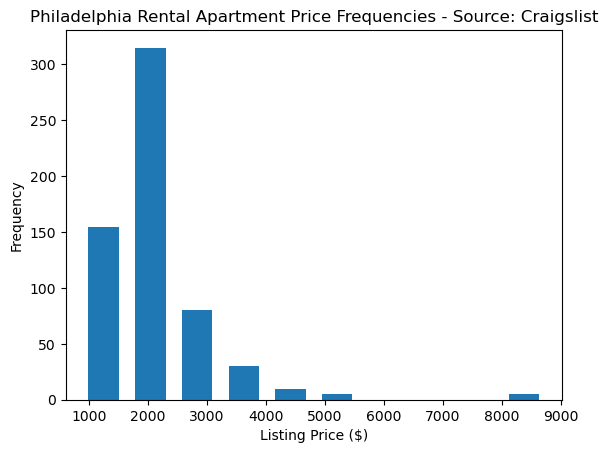

In [199]:
fig,ax = plt.subplots(1,1)
ax.hist(
    results["price"],
    rwidth=0.65,
)
ax.set_title("Philadelphia Rental Apartment Price Frequencies - Source: Craigslist")
ax.set_xlabel("Listing Price ($)")
ax.set_ylabel("Frequency")

plt.show()

#### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

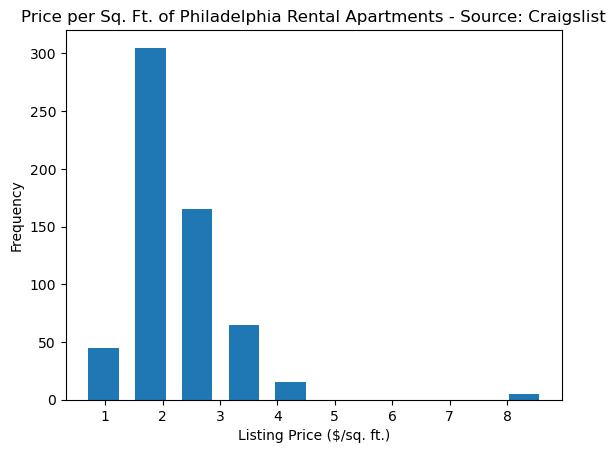

In [226]:
fig,ax = plt.subplots(1,1)
ax.hist(
    results["price"]/results["size"],
    rwidth=0.65
)

ax.set_title("Price per Sq. Ft. of Philadelphia Rental Apartments - Source: Craigslist")
ax.set_xlabel("Listing Price ($/sq. ft.)")
ax.set_ylabel("Frequency")

plt.show()

### 2.8 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [224]:
import altair as alt

colormap = alt.Scale(
    domain=[0,1,2,3,4,5],
    range=[
        "steelblue",
        "cornflowerblue",
        "chartreuse",
        "#F4D03F",
        "#D35400",
        "red",
    ])

# Step 1: Initialize the chart with the data
scatter = alt.Chart(results).mark_circle(size=50).encode(
    x=alt.X('price:Q'),
    y=alt.Y('size:Q'),
    color=alt.Color('bedrooms:Q',sort="ascending",scale=colormap),
    tooltip=["title", "price","size","bedrooms"],
).properties(width=350,height=150)

scatter.interactive()


alt.Chart(...)